# Práctica 3 - Contraste de hipótesis

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving newsletter.csv to newsletter.csv


## Problema 1: Testeando la nueva newsletter


### Parte 1: ¿Qué test llevamos a cabo?

Amason Prime es un e-commerce que, tal y como indica su nombre, se dedica a la venta de números primos por Internet. Uno de sus canales de venta es su newsletter, con la que logra vender números primos a una serie de clientes muy targetizados. Es uno de sus canales más cuidados y, como hay que estar en constante cambio para adaptarse a los movimientos del mercado, han decidido probar con nuevos estilos y diseños en su newsletter.

La dirección recibe cinco propuestas distintas y, para decidir con cuál se queda, se dispone a llevar a cabo un **test AB**. Para ello realiza cinco selecciones aleatorias de direcciones de correo y manda cada uno de los modelos a un grupo con el objetivo de observar su performance.

Descárgate el fichero `newsletter.csv`, que contiene datos del click-through rate (CTR) de cada newsletter. Observa los datos y razona qué test podríamos realizar. El modelo 0 es el modelo control, que es la newsletter actual.

In [ ]:
import io
import numpy as np
import pandas as pd

In [ ]:
path = io.BytesIO(uploaded['newsletter.csv'])
df = pd.read_csv(path, sep=",")

df

,ID,model,click
0,1,3,0
1,2,0,0
2,3,5,0
3,4,5,1
4,5,1,0
...,...,...,...
14995,14996,1,0
14996,14997,3,0
14997,14998,3,1
14998,14999,2,0


Podemos comenzar explorando un poco los datos. Como al final queremos saber qué newsletter es mejor, la idea sería cuál de ellas tuvo mayor click-through rate; esto es, el cociente entre el número de clicks y el número de visualizaciones.

Como la variable `click` es binaria, bastará con usar el método `groupby` sobre la variable `model`, aplicando el método `mean` al final de todo.

In [ ]:
click_through_rate = df.groupby("model")["click"].mean()

print(click_through_rate)

model
0    0.216981
1    0.225207
2    0.215174
3    0.059353
4    0.218762
5    0.290684
Name: click, dtype: float64


In [ ]:
df.groupby(by="model", as_index=False).mean().drop("ID", axis=1).sort_values(by="click", ascending=False)

,model,click
5,5,0.290684
1,1,0.225207
4,4,0.218762
0,0,0.216981
2,2,0.215174
3,3,0.059353


Parece que el modelo 5 tiene más éxito, pero esta información es incompleta sin saber cuantas newsletter de cada tipo se han mandado.

Podemos ver ambas informaciones usando el método `agg` tras el `groupby`.

In [ ]:

agg_data = df.groupby("model").agg({"click": "mean", "ID": "count"})

print(agg_data)

          click    ID
model                
0      0.216981  2544
1      0.225207  2531
2      0.215174  2412
3      0.059353  2443
4      0.218762  2569
5      0.290684  2501


In [ ]:
df.groupby(by="model", as_index=False).agg({"click": ["mean", "count"]}).sort_values(by=("click", "mean"), ascending=False)

model     click      
             mean count
5     5  0.290684  2501
1     1  0.225207  2531
4     4  0.218762  2569
0     0  0.216981  2544
2     2  0.215174  2412
3     3  0.059353  2443

Como los tamaños muestrales de cada grupo son bastante parecidos, una primera aproximación bastante razonable es que el modelo 5 es mejor que el resto.

Tratemos, pues, de probar esta hipótesis. Podemos hacerlo de dos maneras: o bien testeamos modelo 5 contra el resto con un **t-test** o un test de proporciones, o bien testeamos todos los modelos con un **test de diferencias significativas honestas (HSD) de Tukey**.

### Parte 2: ¿Qué tal es mi newsletter actual?

Lo primero que quieren averiguar los data scientists es si, de las propuestas recibidas, hay alguna con peor performance que la newsletter actual. Compara el click-through rate de la muestra que recibió la newsletter actual con cada una de las otras muestras y decide qué versiones debemos descartar.

Podemos testear el modelo control (0) contra cada uno de los demás y ver en qué casos la diferencia es significativa. Combinando los resultados con los ratings del paso 1, sabremos si podemos descartar algún modelo de entrada.

In [ ]:
from scipy.stats import ttest_ind # Las muestras son independientes, pues cada destinatario recibe un único modelo de nl.

In [ ]:
for md in [1, 2, 3, 4, 5]:

  print("0 vs " + str(md), ttest_ind(df[df.model==0].click, df[df.model==md].click).pvalue)

0 vs 1 0.4802223994850019
0 vs 2 0.8772592894747556
0 vs 3 1.9799179344169008e-59
0 vs 4 0.8774403101197469
0 vs 5 1.68096277478576e-09


Los modelos 3 y 5 aparecen significativamente distintos del modelo control, con el 3 teniendo una puntuación inferior. Podemos, pues, descartar el modelo 3 de entrada.

### Parte 3: Escogiendo la nueva newsletter

Con las versiones restantes, diseña un test para comprobar que hay algunas versiones con mejor performance que otras. ¿Hay algún modo de decidir qué newsletter es mejor? En caso afirmativo, defiende tu propuesta.

Apliquemos los tests propuesto en el paso 1:

**Con un t-test**

Una idea es comparar el modelo 5 con el resto, a ver si sale una diferencia significativa.

In [ ]:
ttest_ind(df[df.model==5].click, df[df.model!=5].click)

Ttest_indResult(statistic=11.679922545748958, pvalue=2.207454839780684e-31)

Sin embargo, sabemos que el 3 lo podemos descartar de entrada; y podría ser que su baja puntuación esté contaminando la comparación con el modelo 5. Vale la pena, pues, excluir los datos del modelo 3 en nuestra comparación:

In [ ]:
ttest_ind(df[df.model==5].click, df[~df.model.isin([3, 5])].click)

Ttest_indResult(statistic=7.594000218023463, pvalue=3.3210137325535764e-14)

Seguimos teniendo un p-valor muy bajo. Con esto tenemos suficiente para decir que el modelo 5 es el mejor de todos, incluso mejor que la muestra control.

**Con un HSD de Tukey**

Nos ahorraremos razonamientos quizá algo imprecisos si directamente tratamos de rankear los modelos por su CTR usando un test HSD de Tukey que compare todas las muestras a la vez.

In [ ]:
df.head()

,ID,model,click
0,1,3,0
1,2,0,0
2,3,5,0
3,4,5,1
4,5,1,0


In [ ]:
import statsmodels.stats.multicomp as multi # scipy no tiene implementación del test de Tukey, hay que ir a la librería statsmodels

newsletter_rank = multi.MultiComparison(df.click, df.model)
results = newsletter_rank.tukeyhsd()

print(results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.0082   0.9 -0.0236  0.0401  False
     0      2  -0.0018   0.9  -0.034  0.0304  False
     0      3  -0.1576 0.001 -0.1897 -0.1255   True
     0      4   0.0018   0.9 -0.0299  0.0335  False
     0      5   0.0737 0.001  0.0418  0.1056   True
     1      2    -0.01   0.9 -0.0423  0.0222  False
     1      3  -0.1659 0.001  -0.198 -0.1337   True
     1      4  -0.0064   0.9 -0.0382  0.0253  False
     1      5   0.0655 0.001  0.0335  0.0974   True
     2      3  -0.1558 0.001 -0.1884 -0.1233   True
     2      4   0.0036   0.9 -0.0286  0.0357  False
     2      5   0.0755 0.001  0.0432  0.1079   True
     3      4   0.1594 0.001  0.1274  0.1914   True
     3      5   0.2313 0.001  0.1991  0.2636   True
     4      5   0.0719 0.001  0.0401  0.1038   True
---------------------------------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


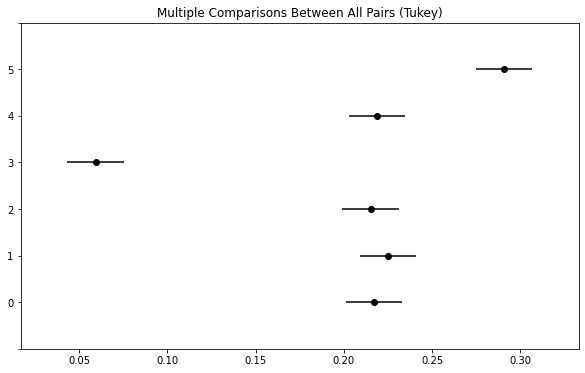

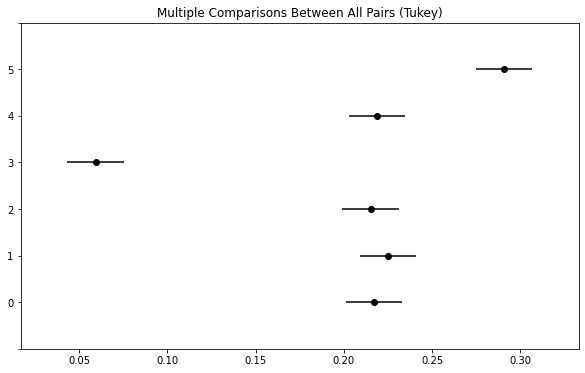

In [ ]:
results.plot_simultaneous()

El test de Tukey nos dice más cosas. Por un lado, el modelo 5 aparece con `True` en todos los emparejamientos, lo cual confirma el resutado del t-test. Pero, además, también nos está diciendo que el modelo 3 es significativamente distinto de los modelos 0, 1, 2 y 4; mientras que 0, 1, 2 y 4 no son significativamente distintos entre ellos. Ello nos permite clusterizar las newsletter por su click-through rate:

1.   modelo 5 (Ganador).
2.   modelos 0, 1, 2 y 4. (Similares, peores que 5)
3.   modelo 3 (el peor).

En efecto, esto cuadra con el ránking que habíamos establecido haciendo el análisis exploratorio y confirma nuestra hipótesis. Queda claro que escogeríamos el modelo 5 como la nueva newsletter de Amason Prime.


Este ejercicio nos muestra la utilidad del test de Tukey: no solamente identifica diferencias significativas entre las medias de varios grupos, sino que además se puede utilizar para hacer **clusterings** sencillos.

# Problema 2: Encuesta de satisfacción


## Parte 1: ¿Cómo se producen los números primos?

Producir números primos no es tarea sencilla. En el pasado, cuando Amason Prime era un negocio pequeño, los generaba artesanalmente con una **criba de Eratóstenes**. Ello garantizaba producir números 100% primos de la mejor calidad. Con el crecimiento del negocio, usar la criba de Eratóstenes ya no resultaba eficiente por el enorme coste de producción de un método con 4000 años de antigüedad. Para modernizarse y poder producir números primos en masa, la compañía comenzó a usar un **test de Solovay-Strassen** para la generación de números primos. Dicho test es mucho más eficiente en la producción de números primos, pero se trata de un método estocástico que, a veces, producirá un número compuesto.

La probabilidad de obtener un número compuesto depende de un número, llamado parámetro de parada. Para averiguar cuál es la mejor estimación de dicho parámetro, se mandan encuestas de satisfacción a los clientes con el producto. En ellas, los compradores han de valorar, de cero a diez, cuan satisfchos están con la primalidad del número recibido.

## Parte 2: ¿Qué tan buenos son mis números primos?

Descárgate el fichero `solovay.csv`, que contiene las puntuaciones de los consumidores y dos parámetros de parada usados para generar el número que 
recibieron. Realiza los tests de hipótesis necesarios para escoger el mejor parámetro en función del feedback del consumidor. Justifica tus elecciones.

In [ ]:
path = io.BytesIO(uploaded['solovay.csv'])
df = pd.read_csv(path, sep=",")

df

,ID,parameter,score
0,1,5,10
1,2,4,10
2,3,5,8
3,4,5,8
4,5,4,10
...,...,...,...
1995,1996,4,6
1996,1997,5,8
1997,1998,4,8
1998,1999,5,8


In [ ]:
df.parameter.unique()

array([5, 4])

Comencemos plotando las distribuciones de datos para tener una primera idea de por dónde tirar:

In [ ]:
h4, b4 = np.histogram(df[df.parameter==4].score, bins=np.arange(11))
h5, b5 = np.histogram(df[df.parameter==5].score, bins=np.arange(11))

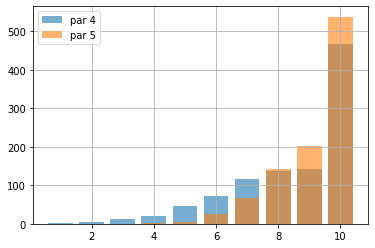

In [ ]:
import matplotlib.pyplot as plt

plt.bar(b4[1:], h4, width=0.8, alpha=0.6, label="par 4")
plt.bar(b5[1:], h5, width=0.8, alpha=0.6, label="par 5")
plt.grid()
plt.legend(loc="best")
plt.show()

De entrada, parece que tenemos dos muestras con distintas varianzas. Comprobémoslo con un test **F de Fisher-Snedecor**:

In [ ]:
from scipy.stats import f

F = np.var(df[df.parameter==4].score) / np.var(df[df.parameter==5].score)
df1, df2 = len(df[df.parameter==4]) - 1, len(df[df.parameter==5]) - 1
p_value = f.cdf(F, df1, df2)

print(np.min([p_value, 1. - p_value]))

1.1102230246251565e-16


El p-valor nos confirma que son muestras procedentes de poblaciones con varianzas distintas. Ello nos impide realizar un t-test para comparar las medias, así que tendremos que recurrir a un test **U de Mann-Whitney**

In [ ]:
from scipy.stats import mannwhitneyu

mannwhitneyu(df[df.parameter==4].score, df[df.parameter==5].score)

MannwhitneyuResult(statistic=419272.0, pvalue=7.480848522487842e-11)

El test de Mann-Whitney nos indica diferencia. Sin embargo, este es un test no-paramétrico, tan solo nos dice que los datos provienen de distributciones distintas. Hemos de ser nosotros quienes decidamos qué las distingue.

En esta caso, tratándose de distribuciones muy apuntadas y con distintas varianzas, lo más seguro es comparar las medianas:

In [ ]:
print(df[df.parameter==4].score.median())
print(df[df.parameter==5].score.median())

8.0
9.0


Los datos indican que un 50% de los encuestados dan una puntuación de 9 o superior al parámetros 5; mientras que para el parámetro 4 la puntuación es un punto inferior. Además, hemos visto que las varianzas eran distintas. Podemos preguntarnos qué valores toman estas varianzas:

In [ ]:
print(df[df.parameter==4].score.std())
print(df[df.parameter==5].score.std())

2.152661378214314
1.4479565397345877


Vemos que el parámetro 4, por un lado, puntúa peor y, por otro, tiene mayor dispersión. Esto se interpreta como que hay menos **consenso** entre los encuestados sobre el valor de dicho parámetro. O, dicho de otra manera, el parámetro 5 es más robusto a nivel de puntuaciones, siendo además mayores en mediana. Con estos dos razonamientos, escogeríamos el parámetro 5 como el idóneo para nuestro algoritmo de Solovay-Strassen.

# Problema: Hagámosle competencia a Amason Prime ###

En este ejercicio vamos a tratar de introducirnos en el lucrativo mercado de los números primos. Como dominamos las mates, hemos decidido que reduciremos costes vendiendo una proporción de números que no son primos pero que lo parecen, los llamados números de Carmichael, entre cuyas hazañas destaca la de engañar al mismísimo Pierre de Fermat. El fichero `carmichael.csv` refleja los resultados de una encuesta de satisfacción realizada a los consumidores en función de si el número mandado es un verdadero primo, un número claramente compuesto o un número de Carmichael.

Propón un plan para determinar si los números de Carmichael están resultando aceptables para los consumidores y lleva a cabo el análisis correspondiente. Defiende los resultados y la conveniencia o no de vender números de Carmichael.

In [ ]:
import io
import numpy as np
import pandas as pd

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving carmichael.csv to carmichael.csv


In [ ]:
path = io.BytesIO(uploaded['carmichael.csv'])
df = pd.read_csv(path, sep=",")

df

,ID,number_type,score
0,1,Prime,7
1,2,Carmichael,10
2,3,Carmichael,10
3,4,Carmichael,1
4,5,Composite,1
...,...,...,...
2995,2996,Composite,2
2996,2997,Prime,7
2997,2998,Composite,0
2998,2999,Prime,9


Primero vamos a empezar a mirar los datos que hay en el fichero, para poder empezar a interpretar qué está sucediendo.

In [ ]:
dfPrime=df[df["number_type"]=='Prime']
dfComposite=df[df["number_type"]=='Composite']
dfCarmichael=df[df["number_type"]=='Carmichael']

print("PRIME: Hay", len(dfPrime.axes[0]), "registros, y la media es", dfPrime["score"].mean())
print("COMPOSITE: Hay", len(dfComposite.axes[0]), "registros, y la media es", dfComposite["score"].mean())
print("CARMICHAEL: Hay", len(dfCarmichael.axes[0]), "registros, y la media es", dfCarmichael["score"].mean())

PRIME: Hay 1021 registros, y la media es 8.573947110675809
COMPOSITE: Hay 980 registros, y la media es 4.208163265306123
CARMICHAEL: Hay 999 registros, y la media es 7.318318318318318


In [ ]:

prime_df = df[df["number_type"] == "prime"]
carmichael_df = df[df["number_type"] == "carmichael"]
composite_df = df[df["number_type"] == "composite"]

total_rows = df.shape[0]

number_type_shares = df["number_type"].value_counts()/total_rows

prime_share = number_type_shares['Prime']
composite_share = number_type_shares['Composite']
carmichael_share = number_type_shares['Carmichael']

print("Porcentaje de clientes que percibieron el número como prim {:.2%}:".format(prime_share))
print("Porcentaje de clientes que percibieron el número como composite {:.2%}:".format(composite_share))
print("Porcentaje de clientes que percibieron el número como carmichael {:.2%}:".format(carmichael_share))


Porcentaje de clientes que percibieron el número como prim 34.03%:
Porcentaje de clientes que percibieron el número como composite 32.67%:
Porcentaje de clientes que percibieron el número como carmichael 33.30%:


A simple vista podemos observar que las 3 muestras tienen aproximadamente el mismo tamaño y la media de la muestra Prime y la de Carmichael tienen un parecido razonable a comparación con la muestra de composite, que esta claramente peor valorada que las anteriores. Para ver más en detalle lo que está sucediendo vamos a plotear las tres muestras.

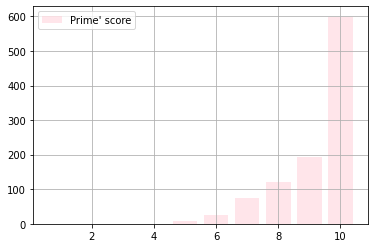

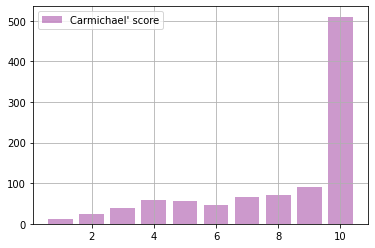

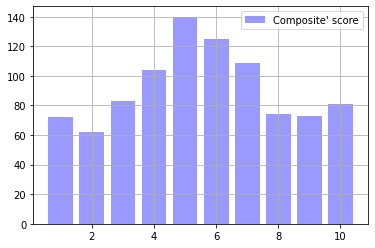

In [ ]:
import matplotlib.pyplot as plt

hPri, bPri = np.histogram(dfPrime.score, bins=np.arange(11))
hCar, bCar = np.histogram(dfCarmichael.score, bins=np.arange(11))
hCom, bCom = np.histogram(dfComposite.score, bins=np.arange(11))

# histograma de la puntuación de satisfacción de los números primos
plt.bar(bPri[1:], hPri, width=0.8, alpha=0.4, label="Prime' score", color=['pink'])
plt.grid()
plt.legend(loc="best")
plt.show()

# histograma de la puntuación de satisfacción para los números de Carmichael
plt.bar(bCar[1:], hCar, width=0.8, alpha=0.4, label="Carmichael' score", color=['purple'])
plt.grid()
plt.legend(loc="best")
plt.show()

# histograma de la puntuación de satisfacción para números compuestos
plt.bar(bCom[1:], hCom, width=0.8, alpha=0.4, label="Composite' score", color=['blue'])
plt.grid()
plt.legend(loc="best")
plt.show()

Por la forma de las gráficas y como las tres distribuciones cumplen el TLC, vamos a aplicar el test de U de Mannwithen para ver si se cumple que las medias son iguales dos a dos para alguna de las combinaciones posibles. 

La prueba U de Mann-Whitney (también conocida como prueba de suma de rangos de Wilcoxon) es una prueba estadística no paramétrica que se puede usar para determinar si dos muestras tienen la misma mediana. Es útil para comparar las medias de dos muestras cuando los datos no cumplen los supuestos de una prueba paramétrica como la prueba t.

In [ ]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(dfPrime.score, dfCarmichael.score))
print(mannwhitneyu(dfPrime.score, dfComposite.score))
print(mannwhitneyu(dfComposite.score, dfCarmichael.score))


MannwhitneyuResult(statistic=572343.0, pvalue=8.395102537966176e-07)
MannwhitneyuResult(statistic=897735.0, pvalue=3.6505851800077686e-211)
MannwhitneyuResult(statistic=226814.5, pvalue=1.6049730930764056e-96)


In [ ]:
from scipy.stats import kruskal

# Perform the Kruskal-Wallis H-test to compare the satisfaction scores of Prime, Carmichael, and Composite numbers
h, p = kruskal(dfPrime.score, dfCarmichael.score, dfComposite.score)

# Print the results
print("H-value:", h)
print("p-value:", p)

H-value: 947.4049794484006
p-value: 1.8776846197405472e-206


Este código utiliza la función kruskal del módulo scipy.stats para realizar la prueba H de Kruskal-Wallis en las puntuaciones de satisfacción de los números primos, los números de Carmichael y los números compuestos.
El valor H es una medida de las diferencias generales entre las muestras, mientras que el valor p es la probabilidad de observar un valor H tan extremo o más extremo que el observado, asumiendo que todas las muestras tienen la misma mediana.



En este caso, el valor H es 947,4049794484006 y el valor p es 1,8776846197405472e-206, que es una probabilidad muy baja, casi 0, lo que indica que existe una diferencia significativa entre las puntuaciones de satisfacción de los números primos, los números de Carmichael y Números compuestos.

Un umbral común para el valor p es 0,05, lo que significa que si el valor p es inferior a 0,05, rechazamos la hipótesis nula de que todas las muestras tienen la misma mediana y concluimos que existe una diferencia significativa entre las muestras. En este caso, el valor p es mucho menor que 0,05, lo que significa que podemos rechazar la hipótesis nula con un alto grado de confianza.

Como observamos, en los tres casos podemos descartar que las medias sean iguales. Sin embargo, se observa que los p-valores entre las muestras prime-composite y carmichael-composite son mucho más pequeñas que la combinación primer-carmichael, por lo que podemos deducir que las medias que distan menos de parecerse más son las de las valoraciones de los numeros primos y los de carmichael.
A continuación, vamos a clusterizar las muestras usando el test de tukey.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#  la prueba de Tukey para comparar las puntuaciones de satisfacción de los números Prime, Carmichael y Composite
tukey = pairwise_tukeyhsd(df["score"], df["number_type"])

print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj  lower   upper  reject
----------------------------------------------------------
Carmichael Composite  -3.1102 0.001 -3.3942 -2.8261   True
Carmichael     Prime   1.2556 0.001  0.9745  1.5368   True
 Composite     Prime   4.3658 0.001  4.0833  4.6483   True
----------------------------------------------------------


# Conclusiones

Viendo que el p-valor es menor que 0.5 en todos los test de U de Man-whitney podemos rechazar las hipotesis nula de que algunas de las medias son iguales dos a dos. 
Por lo que en conclusión, aunque incialmente las dos muestras tienen unos valores parecidos, y podriamos llegar a suponer que las valoraciones de los clientes son relativamente parecidas, podemos asumir que esto no es así y que los consumidores prefieren los números primos.

No obstante, mediante estos tests y los datos del test de tukey, podemos observar que las medias que son más similares son las de las muestras de las valoraciones de los números primos y los de Carmichael.

Por ello, aunque aparentemente la satisfación de cliente con los números de Carmichael es peor a la de los Primos, deberíamos estudiar el coste-beneficio que tiene este mercado para poder investigar más en detalle si es más rentable el negocio de compentencia a Amason Prime.

Finalmente, basándonos solo en los resultados del test, y como inversor, no invertiría ni aconsejaría invertir en el negocio de los números de Carmichael, sino que encontrando la manera más rentable posible, seguiria apostando por un negocio que calculara números primos fiables.

Conclusiones:

- Las medias de las puntuaciones de satisfacción de los números primos y los números de Carmichael no son significativamente diferentes entre sí, pero sí lo son con respecto a la media de las puntuaciones de satisfacción de los números compuestos.
- La media de las puntuaciones de satisfacción de los números compuestos es significativamente menor que las medias de las puntuaciones de satisfacción de los números primos y los números de Carmichael.
- Las puntuaciones de satisfacción de los números primos y los números de Carmichael son más similares entre sí, pero viendo que el p-valor es menor que 0.5 en todos los test de U de Man-whitney podemos rechazar las hipotesis nula de que algunas de las medias son iguales dos a dos.

En base a estas conclusiones, podemos decir que vender números de Carmichael a los consumidores no es una buena idea ya que los resultados no son tan buenos como los de los números primos y los consumidores no están tan satisfechos con ellos como con los números primos.